# Detecção de Infarto do miocárdio usando sinais ECG
O presente documento é a representação da rede neural do artigo: "Application of deep convolutional neural network for automated detection of myocardial infarction using ECG signals".
<br>
Retirado em: <a href= "https://www.sciencedirect.com/science/article/pii/S0020025517308009"> Application of deep convolutional neural network for automated detection of myocardial infarction using ECG signals </a>
## Artigo
O artigo utiliza redes neurais convolucionais para detectar automaticamente infarto do coração. Dois modelos diferentes foram utilizados, um com ruído e outro sem. Aqui reproduziremos a arquitetura com os ruídos.
## Database
Os dados foram retirados de: <a href= "https://www.physionet.org/content/ptbdb/1.0.0/"> PTB Diagnostic ECG Database </a>. Apesar de ter 9 classes, somente 2 foram utilizadas, as de pessoas saudáveis (52) e de infarto do miocárdio(148). Outro fator importante é que são utilizados 12 leads para classificação, entretanto somento o lead II é usado. Por último, a frequência de obtenção de sinais é de 2KHz.

In [524]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [525]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Carregar os dados

In [526]:
# Carregar a tabela csv
df = pd.read_csv("batimentos.csv")

cols = ['n']
for i in range(326):
    cols.append(str(i))
cols.append("Arritmia")
cols.append("Lead")
df.columns = cols
df.head()

,n,0,1,2,3,4,5,6,7,8,...,318,319,320,321,322,323,324,325,Arritmia,Lead
0,0,-0.007,-0.010,-0.012,-0.007,-0.003,-0.002,-0.002,-0.005,-0.019,...,0.001,-0.015,-0.030,-0.029,-0.018,-0.012,-0.010,-0.006,426627000.0,0.0
1,1,-0.014,-0.005,-0.001,0.003,0.019,0.030,0.038,0.033,0.025,...,0.020,0.023,0.023,0.021,0.011,0.008,0.011,0.003,426627000.0,0.0
2,2,-0.005,0.010,0.027,0.021,0.021,0.011,0.002,0.000,-0.004,...,-0.037,-0.030,-0.013,-0.004,-0.007,-0.017,-0.020,-0.025,426627000.0,0.0
3,3,0.015,0.030,0.018,-0.004,-0.013,-0.012,0.000,-0.002,0.001,...,0.004,-0.008,-0.017,-0.009,-0.007,0.001,-0.007,-0.025,426627000.0,0.0
4,4,0.035,0.031,0.030,0.026,0.016,-0.003,-0.009,0.000,-0.004,...,0.001,-0.015,-0.012,-0.007,-0.010,-0.008,-0.005,-0.002,426627000.0,0.0


In [527]:
df['Arritmia'].unique()

array([4.26627000e+08, 4.26783006e+08])

In [528]:
df.loc[lambda df: df["Arritmia"] == 426783006.0, "Arritmia"] = 0

In [529]:
df.loc[lambda df: df["Arritmia"] == 426627000.0, "Arritmia"] = 1

In [530]:
df['Arritmia'].unique()

array([1., 0.])

(array([3365.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2377.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

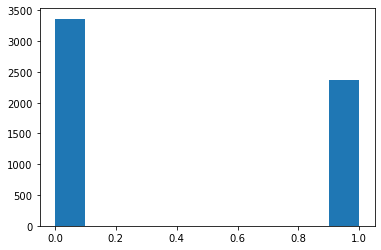

In [531]:
plt.hist(df.loc[:,"Arritmia"])

In [532]:
total_size = df.shape[0]

train_size = int(0.63 * total_size)
validation_size = int(0.27 * total_size)
test_size = total_size - (validation_size + train_size)

print(f"Train size: {train_size}, Validation size: {validation_size},\
 Test size: {test_size}")


Train size: 3617, Validation size: 1550, Test size: 575


In [533]:
df.head()

,n,0,1,2,3,4,5,6,7,8,...,318,319,320,321,322,323,324,325,Arritmia,Lead
0,0,-0.007,-0.010,-0.012,-0.007,-0.003,-0.002,-0.002,-0.005,-0.019,...,0.001,-0.015,-0.030,-0.029,-0.018,-0.012,-0.010,-0.006,1.0,0.0
1,1,-0.014,-0.005,-0.001,0.003,0.019,0.030,0.038,0.033,0.025,...,0.020,0.023,0.023,0.021,0.011,0.008,0.011,0.003,1.0,0.0
2,2,-0.005,0.010,0.027,0.021,0.021,0.011,0.002,0.000,-0.004,...,-0.037,-0.030,-0.013,-0.004,-0.007,-0.017,-0.020,-0.025,1.0,0.0
3,3,0.015,0.030,0.018,-0.004,-0.013,-0.012,0.000,-0.002,0.001,...,0.004,-0.008,-0.017,-0.009,-0.007,0.001,-0.007,-0.025,1.0,0.0
4,4,0.035,0.031,0.030,0.026,0.016,-0.003,-0.009,0.000,-0.004,...,0.001,-0.015,-0.012,-0.007,-0.010,-0.008,-0.005,-0.002,1.0,0.0


In [534]:
header = df.columns

In [535]:
header

Index(['n', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '318', '319', '320', '321', '322', '323', '324', '325', 'Arritmia',
       'Lead'],
      dtype='object', length=329)

In [536]:
from torch.utils.data.dataset import Dataset

class Batimentos(Dataset):
  def __init__(self):
    xy = df
    self.x = torch.tensor(df[header[1:-2]].values, dtype= torch.float32).view(len(df),1,-1)
    self.y = torch.tensor((df[header[-2]].values), dtype= int)
    self.tamanho = xy.shape[0]
  
  def __len__(self):
    return self.tamanho
  
  def __getitem__(self, index):
    return self.x[index], self.y[index]

In [537]:
dataset = Batimentos()

In [563]:
from torch.utils.data import DataLoader


batch_size = 32
train_data, validation, test_data = torch.utils.data.random_split(dataset, [train_size, validation_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle= True)
valid_loader = torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle= False)

In [564]:
data, label = next(iter(train_loader))
print(data, label)
print(data.shape)

tensor([[[-0.2530, -0.2680, -0.2870,  ...,  0.1010,  0.1200,  0.1120]],

        [[-0.0780, -0.0850, -0.0820,  ..., -0.0470, -0.0500, -0.0500]],

        [[-0.1250, -0.1000, -0.1580,  ..., -0.2110, -0.2220, -0.1450]],

        ...,

        [[ 0.0250,  0.0260,  0.0220,  ..., -0.0640, -0.0640, -0.0600]],

        [[-0.0400, -0.0390, -0.0380,  ..., -0.0380, -0.0350, -0.0350]],

        [[-0.0400, -0.0400, -0.0400,  ..., -0.0400, -0.0400, -0.0400]]]) tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 1, 326])


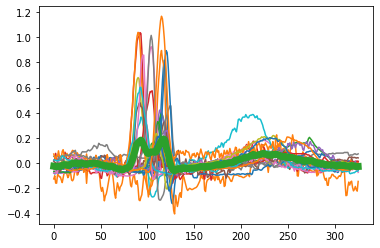

In [565]:
plt.plot(data[label==0,0,:].T);
plt.plot(data[label==0,0,:].T.mean(axis=1),linewidth=7);

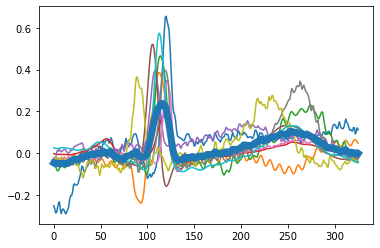

In [566]:
plt.plot(data[label==1,0,:].T);
plt.plot(data[label==1,0,:].T.mean(axis=1),linewidth=7);

In [567]:
len(train_loader.dataset)

3617

## Arquitetura

In [543]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Entrada de um vetor de 651 dados 
        self.conv1 = nn.Conv1d(1, 3, 102, padding=1)
        self.conv2 = nn.Conv1d(3, 10, 24, padding=1)
        self.conv3 = nn.Conv1d(10, 10, 11, padding=1)
        self.conv4 = nn.Conv1d(10, 10, 9, padding=1)
        self.pool = nn.MaxPool1d(2, stride= 2)
        self.fc1 = nn.Linear(60, 30)
        self.fc2 = nn.Linear(30, 10)
        self.fc3 = nn.Linear(10, 2)
        # Without Learnable Parameters
        self.batch1 = nn.BatchNorm1d(10, affine=False)

    def forward(self, x):
        # Muda o shape da convolução 1D
        #x = x.reshape(x.shape[0],1,-1)
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.batch1(self.pool(F.leaky_relu(self.conv2(x))))
        x = self.batch1(self.pool(F.leaky_relu(self.conv3(x))))
        x = self.batch1(self.pool(F.leaky_relu(self.conv4(x))))
        
        # flatten image input
        x = x.view(x.size(0), -1)


        # FC com leaky_relu
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        #x = F.softmax(self.fc3(x))
        x = self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv1d(1, 3, kernel_size=(102,), stride=(1,), padding=(1,))
  (conv2): Conv1d(3, 10, kernel_size=(24,), stride=(1,), padding=(1,))
  (conv3): Conv1d(10, 10, kernel_size=(11,), stride=(1,), padding=(1,))
  (conv4): Conv1d(10, 10, kernel_size=(9,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=60, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
  (batch1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)


In [544]:
if train_on_gpu:
    data = data.cuda()
tmp = model.pool(F.leaky_relu(model.conv1(data)))
print(tmp.shape)
tmp = model.pool(F.leaky_relu(model.conv2(tmp)))
print(tmp.shape)
tmp = model.pool(F.leaky_relu(model.conv3(tmp)))
print(tmp.shape)
tmp = model.pool(F.leaky_relu(model.conv4(tmp)))
print(tmp.shape)
tmp = tmp.view(tmp.size(0), -1)
print(tmp.shape)
tmp = F.leaky_relu(model.fc1(tmp))
print(tmp.shape)
tmp = F.leaky_relu(model.fc2(tmp))
print(tmp.shape)
tmp = model.fc3(tmp)
print(tmp.shape)
print(model(data))

torch.Size([32, 3, 113])
torch.Size([32, 10, 46])
torch.Size([32, 10, 19])
torch.Size([32, 10, 6])
torch.Size([32, 60])
torch.Size([32, 30])
torch.Size([32, 10])
torch.Size([32, 2])
tensor([[ 0.1559,  0.0037],
        [ 0.1051, -0.0013],
        [ 0.0730, -0.0440],
        [ 0.0819,  0.0483],
        [ 0.1285, -0.0098],
        [ 0.0408, -0.0891],
        [ 0.1700,  0.0460],
        [ 0.1481,  0.0717],
        [ 0.0965, -0.0680],
        [-0.0600, -0.0388],
        [ 0.1016, -0.0509],
        [ 0.0294, -0.0304],
        [ 0.0522, -0.0065],
        [ 0.1253,  0.0473],
        [ 0.1221,  0.0079],
        [ 0.1264, -0.0066],
        [ 0.1096, -0.0604],
        [ 0.1879,  0.0169],
        [ 0.1557,  0.0998],
        [ 0.0748, -0.0512],
        [ 0.1909,  0.0164],
        [ 0.1019, -0.0173],
        [ 0.1626,  0.0982],
        [ 0.1265, -0.0273],
        [ 0.0701, -0.0634],
        [ 0.0390,  0.0213],
        [ 0.1171,  0.0295],
        [ 0.0692, -0.0241],
        [ 0.1108, -0.0108],
      

the regularization, momentum, and learning rate parameters are set to 0.2, 3 × 10 −4 , and 0.7 respectively.

In [545]:
import torch.optim as optim

regularization = 0.2
momentum = 3e-4
lr = 0.005

criterion = nn.CrossEntropyLoss()

optmizer = optim.SGD(model.parameters(), lr= lr)#, momentum= momentum, weight_decay= regularization)

## Treino

In [546]:
def train_model(nEpochs = 10):
    train_loss_list =[]
    valid_loss_list = []

    valid_loss_min = np.Inf # Minimo valid loss

    for epoch in range(nEpochs):
        train_loss= 0
        validation_loss= 0

        model.train()
        for sample, target in train_loader:
            if train_on_gpu:
                sample, target = sample.cuda(), target.cuda()
        # Zerar o gradiente
            optmizer.zero_grad()
        # Gera saída do modelo
            outputs = model(sample)
        # Calcula o erro
            loss = criterion(outputs, target)
            train_loss+=loss.item()*sample.size(0)
        # Calcula os gradientes
            loss.backward()
        # Otimiza o modelo
            optmizer.step()
            
        model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            validation_loss += loss.item()*data.size(0)

        train_loss = train_loss/len(train_loader.dataset)
        train_loss_list.append(train_loss)
        
        validation_loss = validation_loss/len(valid_loader.dataset)
        valid_loss_list.append(validation_loss)
      
        if (not epoch%5):
            print(f"Época: {epoch} \nLoss Treino: {train_loss}")
            print(f"Loss validação: {validation_loss}")

        if validation_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min, validation_loss))
            torch.save(model.state_dict(), 'modelo_arritmia.pt')
            valid_loss_min = validation_loss

    return train_loss_list, valid_loss_list


In [547]:
trained_data, validated_data = train_model(100)

Época: 0 
Loss Treino: 0.6783814969101036
Loss validação: 0.6841912397261589
Validation loss decreased (inf --> 0.684191).  Saving model ...
Validation loss decreased (0.684191 --> 0.682984).  Saving model ...
Validation loss decreased (0.682984 --> 0.682896).  Saving model ...
Época: 5 
Loss Treino: 0.5375374389643955
Loss validação: 0.7795529962355091
Época: 10 
Loss Treino: 0.5094920757036364
Loss validação: 1.1017764683692686
Época: 15 
Loss Treino: 0.45151854533664026
Loss validação: 1.2566432137643138
Época: 20 
Loss Treino: 0.40450486644406264
Loss validação: 1.8716582564384707
Época: 25 
Loss Treino: 0.3994709009400942
Loss validação: 2.1992274738127184
Época: 30 
Loss Treino: 0.41128979610546473
Loss validação: 2.6537092870281587
Época: 35 
Loss Treino: 0.331390255519887
Loss validação: 1.6954123655442268
Época: 40 
Loss Treino: 0.40310718112140853
Loss validação: 2.3629575233305653
Época: 45 
Loss Treino: 0.33797995163808053
Loss validação: 2.374015283276958
Época: 50 
Loss T

In [548]:
len(trained_data)

100

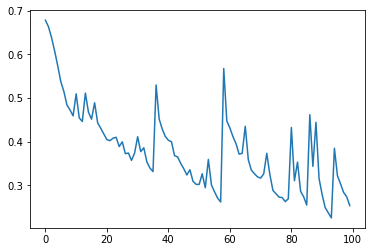

In [549]:
plt.plot(trained_data)

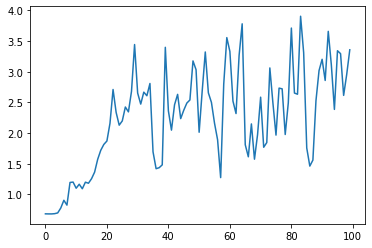

In [550]:
plt.plot(validated_data)

## Teste

In [551]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [552]:
# Matriz de confusão
def createCM(loader,model,nClasses):
  model.eval()

  accuracy = 0
  CM = np.zeros((nClasses,nClasses))
  y_pred = []
  y_true = []

  for sample1, target1 in loader:

    if train_on_gpu:
      sample1, target1 = sample1.cuda(), target1.cuda()
      model.cuda()

    prediction = model(sample1)
    outputsClass = torch.argmax(prediction, dim=1)

    if train_on_gpu:
      yt = np.array([t.cpu().numpy() for t in outputsClass])
      yp = np.array([t.cpu().numpy() for t in target1])

    else:
      yt = np.array([t.numpy() for t in outputsClass])
      yp = np.array([t.numpy() for t in target1])
      
    for x in range(len(yp)):
      y_pred.append(yp.item(x))
    for x in range(len(yt)):
      y_true.append(yt.item(x))

  CM = confusion_matrix(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  return CM, accuracy

In [553]:
matriz, acuracia = createCM(test_loader,model,2)

In [554]:
matriz

array([[  1,   0],
       [333, 241]])

In [555]:
acuracia

0.42086956521739133

In [556]:
model_saved = Net()
model.load_state_dict(torch.load('modelo_arritmia.pt'))
model.eval()

Net(
  (conv1): Conv1d(1, 3, kernel_size=(102,), stride=(1,), padding=(1,))
  (conv2): Conv1d(3, 10, kernel_size=(24,), stride=(1,), padding=(1,))
  (conv3): Conv1d(10, 10, kernel_size=(11,), stride=(1,), padding=(1,))
  (conv4): Conv1d(10, 10, kernel_size=(9,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=60, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
  (batch1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [557]:
matriz, acuracia = createCM(test_loader,model,2)
matriz

array([[334, 241],
       [  0,   0]])

In [558]:
acuracia

0.5808695652173913